**FlyVis Perturbations: Evaluate Model Performance**

This notebook will take in FlyVis models (pre-trained on optic flow task) that have been systematically perturbed in their connectivity, and then output various performance metrics on visual classification tasks and neuron tuning properties.

INPUTS: [FlyVis model]

OUTPUTS: {NETWORK}_performance.h5py

In [4]:
import os
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch

# flyvis imports
from flyvis import NetworkView
from flyvis.datasets.rendering import BoxEye
from flyvis.analysis.animations import HexScatter


import h5py
import datamate.io        # Where the function is defined
import datamate.directory # Where the function is actually CALLED causing the error

# Set up plotting
plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["font.size"] = 6
plt.rcParams["figure.dpi"] = 200


data_path = Path("data/flyvis_data")
data_path.mkdir(parents=True, exist_ok=True)

env = os.environ.copy()
env["FLYVIS_ROOT_DIR"] = str(data_path)

In [6]:
def fixed_write_h5(path, val):
    """
    A Windows-safe replacement that skips the 'read-before-write' check.
    """
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    # Simple, safe write. No checking 'f["data"]', no 'unlink'.
    # This completely bypasses the logic causing your KeyError.
    with h5py.File(path, mode="w", libver="latest") as f:
        f.create_dataset("data", data=val)

# --- STEP 2: APPLY THE PATCH EVERYWHERE ---
print("Applying aggressive patches...")

# Patch 1: The definition
datamate.io._write_h5 = fixed_write_h5

# Patch 2: The copy inside directory.py (THIS IS THE KEY FIX)
# This forces the Directory class to use OUR function, not the old one it imported.
if hasattr(datamate.directory, "_write_h5"):
    datamate.directory._write_h5 = fixed_write_h5
    print(" -> Patched datamate.directory._write_h5")
else:
    print(" -> Warning: Could not find _write_h5 in directory module")


print("Importing flyvis...")
from flyvis import NetworkView


Applying aggressive patches...
 -> Patched datamate.directory._write_h5
Importing flyvis...


In [28]:
from flyvis import results_dir
from flyvis.network import NetworkView

# model are already sorted by task error
# we take the best task-performing model from the pre-sorted ensemble
network_view = NetworkView(data_path / "results/flow/0000/000_p")

[2026-01-06 19:30:12] network_view:122 Initialized network view at C:\Users\dean\Documents\dev\fly_winter_school\fly_wire_perturbations\data\flyvis_data\results\flow\0000\000_p


In [10]:
import pandas as pd
cell_type_df = pd.read_csv(f'{data_path}/flyvis_cell_type_connectivity.csv')

In [ ]:
# cell_type_df[cell_type_df.target_type == 'T1']

### Pert 

In [24]:
# Now perturb
from flyvis_cell_type_pert import FlyvisCellTypePert, PerturbationType
pert = FlyvisCellTypePert()

pairs_to_perturb = [('C2', 'T1'), ('Am', 'T1')]
pert.perturb(
    cell_type_df,
    perturbation_type=PerturbationType.PAIR_WISE,
    pairs=pairs_to_perturb
)

print("Perturbed connections:")
print(pert.pert_conn[pert.pert_conn.pert_weight == 0])

Perturbed connections:
   source_type target_type  sign  syn_count  pert_weight
10          Am          T1   1.0        721            0
19          C2          T1  -1.0        721            0


In [25]:
from copy import deepcopy

original_network = network_view.init_network()
perturbed_network = deepcopy(original_network)

# Check and apply perturbation
def get_pair_index_in_network(network, source_type, target_type):
    syn_str = network.edge_params.syn_strength.keys
    for idx, (src, tar) in enumerate(syn_str):
        if src == source_type and tar == target_type:
            return idx
    return None


for pair in pairs_to_perturb:
    print()
    idx = get_pair_index_in_network(original_network, pair[0], pair[1])
    print(f'{pair[0]} -> {pair[1]} index: {idx}')

    weight_original_before = original_network.edge_params.syn_strength.raw_values[idx].item()
    weight_pert_before = perturbed_network.edge_params.syn_strength.raw_values[idx].item()
    print(f'Original network {pair[0]}->{pair[1]} weight before: {weight_original_before}')
    print(f'Perturbed network {pair[0]}->{pair[1]} weight before: {weight_pert_before}')

# Apply perturbatio
print('applying perturbation...')
pert.override_network(perturbed_network)
for pair in pairs_to_perturb:
    print()
    idx = get_pair_index_in_network(original_network, pair[0], pair[1])
    print(f'{pair[0]} -> {pair[1]} index: {idx}')

    weight_pert_after = perturbed_network.edge_params.syn_strength.raw_values[idx].item()
    weight_original_after = original_network.edge_params.syn_strength.raw_values[idx].item()
    print(f'Original network {pair[0]}->{pair[1]} weight after (should be unchanged): {weight_original_after}')
    print(f'Perturbed network {pair[0]}->{pair[1]} weight after: {weight_pert_after}')


[2026-01-06 19:26:56] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2026-01-06 19:26:56] chkpt_utils:36 Recovered network state.



C2 -> T1 index: 140
Original network C2->T1 weight before: 4.58910217275843e-05
Perturbed network C2->T1 weight before: 4.58910217275843e-05

Am -> T1 index: 131
Original network Am->T1 weight before: 0.003842476522549987
Perturbed network Am->T1 weight before: 0.003842476522549987
applying perturbation...

C2 -> T1 index: 140
Original network C2->T1 weight after (should be unchanged): 4.58910217275843e-05
Perturbed network C2->T1 weight after: 0.0

Am -> T1 index: 131
Original network Am->T1 weight after (should be unchanged): 0.003842476522549987
Perturbed network Am->T1 weight after: 0.0


**Plot receptive and projective fields**

### Plot neural traces

In [16]:
#supply random stimulus
from flyvis.utils.hex_utils import get_num_hexals

# Stimulation time and time step
T = 1  # seconds
dt = 1 / 50  # 1 / 200

# Create a random stimulus
stimulus = torch.randn(
    1, int(T / dt), 1, get_num_hexals(original_network.connectome.config.extent)
)

# Add the stimulus to a stimulus buffer
# For now, do this in parallel to original and perturbed networks
original_network.stimulus.add_input(stimulus)
perturbed_network.stimulus.add_input(stimulus)
# Run the model
with torch.no_grad():
    original_activity = original_network(original_network.stimulus(), dt=dt)
    perturbed_activity = perturbed_network(perturbed_network.stimulus(), dt=dt)

In [17]:
print("Shape of the original network activity:", original_activity.shape)
print("Shape of the perturbed network activity:", perturbed_activity.shape )

Shape of the original network activity: torch.Size([1, 50, 45669])
Shape of the perturbed network activity: torch.Size([1, 50, 45669])


example: visualize L3 (Am3-L3 synapses pertuerbed)
TO DO: change this so it automatically visualized perturbed cell type and its downstream partners

In [18]:
from flyvis.utils.activity_utils import LayerActivity as ActivityByType

original_activity_by_type = ActivityByType(original_activity, original_network.connectome, keepref=True)
perturbed_activity_by_type = ActivityByType(perturbed_activity, perturbed_network.connectome, keepref=True)
print("Shape of the activity:", original_activity_by_type.L3[:].shape)

Shape of the activity: torch.Size([1, 50, 721])


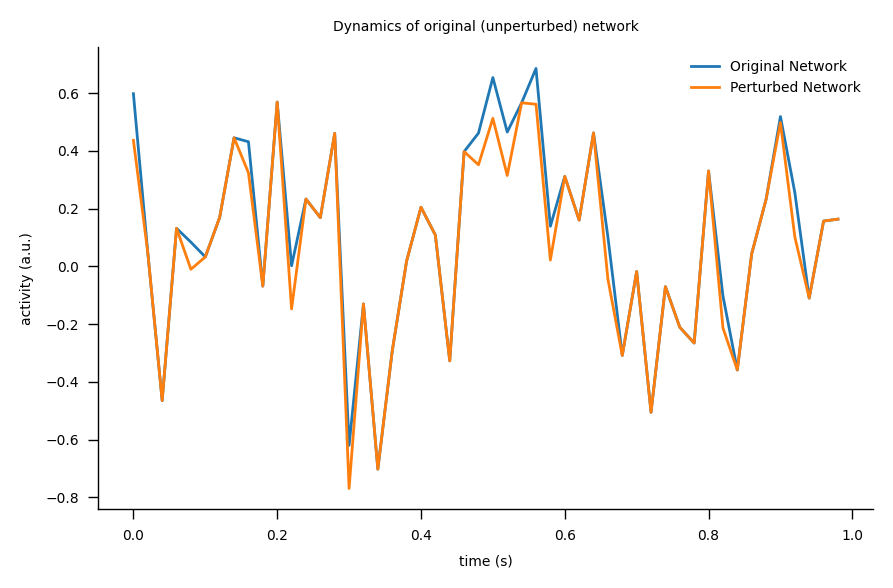

<Figure size 1000x600 with 0 Axes>

In [19]:
time = np.arange(0, original_activity.shape[1]) * dt
neuron_idx = 0
plt.plot(time, original_activity_by_type.T1[:,:,neuron_idx].squeeze().cpu(), label='Original Network')
plt.xlabel("time (s)")
plt.ylabel("activity (a.u.)")
plt.title("Dynamics of original (unperturbed) network")

plt.plot(time, perturbed_activity_by_type.T1[:,:,neuron_idx].squeeze().cpu(), label='Perturbed Network')
plt.legend()
plt.show()
plt.tight_layout()

### Plot response to Sintel movie set (naturalistic stimuli)

 ### Plot tuning curves for direction and orientation selectivity

Implement FlyVis moving edge stimulus and create tuning curve, then compare tuning curve for original, perturbed, and ground truth exp. data

In [ ]:
from flyvis.datasets.moving_bar import MovingEdge
from flyvis.analysis.animations.hexscatter import HexScatter

In [ ]:
# initialize dataset
# make the dataset
dataset = MovingEdge(
    offsets=[-10, 11],  # offset of bar from center in 1 * radians(2.25) led size
    intensities=[0, 1],  # intensity of bar
    speeds=[19],  # speed of bar in 1 * radians(5.8) / s
    height=80,  # height of moving bar in 1 * radians(2.25) led size
    post_pad_mode="continue",  # for post-stimulus period, continue with the last frame of the stimulus
    t_pre=1.0,  # duration of pre-stimulus period
    t_post=1.0,  # duration of post-stimulus period
    dt=1 / 200,  # temporal resolution of rendered video
    angles=list(np.arange(0, 360, 30)),  # motion direction (orthogonal to edge)
)

In [ ]:
# # view stimulus parameters
# dataset.arg_df
# # the dataset has four samples, one corresponding to each row

# # visualize single sample
# # %#matplotlib notebook
# animation = HexScatter(
#     dataset[3][None, ::25, None], vmin=0, vmax=1
# )  # intensity=1, radius=6
# animation.animate_in_notebook()

In [ ]:
stims_and_resps = network_view.moving_edge_responses(dataset)

In [ ]:
type(stims_and_resps)
stims_and_resps['responses'].shape

In [ ]:
stims_and_resps['responses'].shape

In [ ]:
stims_and_resps.responses.shape

In [ ]:
stims_and_resps.cell_type.values

In [ ]:
from flyvis.analysis.moving_bar_responses import preferred_direction
from flyvis.analysis.moving_bar_responses import dsi_correlation_to_known
from flyvis.analysis.moving_bar_responses import direction_selectivity_index
from flyvis.analysis.moving_bar_responses import correlation_to_known_tuning_curves

pds = preferred_direction(stims_and_resps)
dsis = direction_selectivity_index(stims_and_resps)


In [ ]:
cell_types_to_collect = ["T4a", "T4b", "T4c", "T4d", "T5a", "T5b", "T5c", "T5d"]
data = []

for cell_type in cell_types_to_collect:
    pd1 = pds.custom.where(cell_type=cell_type, intensity=1).item()
    pd0 = pds.custom.where(cell_type=cell_type, intensity=0).item()

    dsi1 = dsis.custom.where(cell_type=cell_type, intensity=1).item()
    dsi0 = dsis.custom.where(cell_type=cell_type, intensity=0).item()

    dsi_corr = dsi_correlation_to_known(direction_selectivity_index(stims_and_resps)).median() # TODO; ask Zina
    corrs = correlation_to_known_tuning_curves(stims_and_resps)
    tc_corr1 = corrs.custom.where(cell_type=cell_type, intensity=1)
    tc_corr0 = corrs.custom.where(cell_type=cell_type, intensity=0)

    # Append row to the list as a dictionary
    data.append({
        'cell_type': cell_type,
        'pd_intensity1': pd1,
        'pd_intensity0': pd0,
        'dsi_intensity1': dsi1,
        'dsi_intensity0': dsi0,
        'dsi_correlation': dsi_corr.item(),
        'tc_correlation_intensity1': tc_corr1.item(),
        'tc_correlation_intensity0': tc_corr0.item()
    })

# Create DataFrame once
results_df = pd.DataFrame(data)
results_df

In [ ]:
from flyvis import results_dir
results_dir

In [ ]:
import shutil
import torch

# Remove the old perturbed directory completely and start fresh


# Copy fresh
shutil.copytree(results_dir / "flow/0000/000", perturbed_results_dir)

# Create network views
original_network_view = NetworkView(results_dir / "flow/0000/000")
perturbed_network_view = NetworkView(perturbed_results_dir)

# Get original responses
original_stims_and_resps = original_network_view.moving_edge_responses(dataset)

# Apply perturbation


temp_network = perturbed_network_view.init_network()


# Load original checkpoint structure
checkpoint_path = perturbed_results_dir / "best_chkpt"
original_checkpoint = torch.load(results_dir / "flow/0000/000" / "best_chkpt", map_location='cpu')
original_checkpoint['network'] = temp_network.state_dict()

# Save to ALL possible checkpoint locations
torch.save(original_checkpoint, checkpoint_path)
print(f"Saved to: {checkpoint_path}")

# Also overwrite chkpts directory if it exists
chkpts_dir = perturbed_results_dir / "chkpts"
if chkpts_dir.exists():
    for chkpt_file in chkpts_dir.glob("*"):
        torch.save(original_checkpoint, chkpt_file)
        print(f"Saved to: {chkpt_file}")

# Remove checkpoints subdirectory if it exists
checkpoints_subdir = perturbed_results_dir / "checkpoints"
if checkpoints_subdir.exists():
    shutil.rmtree(checkpoints_subdir)
    print(f"Removed: {checkpoints_subdir}")

# Clear cache
cache_dir = perturbed_results_dir / "__cache__"
if cache_dir.exists():
    shutil.rmtree(cache_dir)

# Get perturbed responses
perturbed_stims_and_resps = perturbed_network_view.moving_edge_responses(dataset)

In [ ]:
# # Calculate difference for each neuron
# diff_per_neuron = np.abs(perturbed_responses.values - original_responses.values).mean(axis=(0, 1, 2))  # Average over network_id, sample, frame

# # Create a dataframe with cell types and their differences
# cell_types = original_responses.cell_type.values
# diff_df = pd.DataFrame({
#     'cell_type': cell_types,
#     'mean_abs_diff': diff_per_neuron
# })

# # Sort by difference
# diff_df_sorted = diff_df.sort_values('mean_abs_diff', ascending=False)

# print("Top 20 most affected cell types:")
# print(diff_df_sorted.head(20))

# # Check if there are ANY changes
# print(f"\nNumber of neurons with non-zero change: {(diff_per_neuron > 1e-9).sum()}")
# print(f"Total number of neurons: {len(diff_per_neuron)}")

# # Visualize top affected cell type
# if diff_df_sorted.iloc[0]['mean_abs_diff'] > 1e-9:
#     top_cell_type = diff_df_sorted.iloc[0]['cell_type']
#     print(f"\nPlotting most affected cell type: {top_cell_type}")
    
#     fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
#     plt.sca(axes[0])
#     original_stims_and_resps["responses"].custom.where(
#         cell_type=top_cell_type, intensity=1, time=">-0.5,<1.0"
#     ).custom.plot_traces(x="time", legend_labels=["angle"])
#     axes[0].set_title(f"Original {top_cell_type} responses")
    
#     plt.sca(axes[1])
#     perturbed_stims_and_resps["responses"].custom.where(
#         cell_type=top_cell_type, intensity=1, time=">-0.5,<1.0"
#     ).custom.plot_traces(x="time", legend_labels=["angle"])
#     axes[1].set_title(f"Perturbed {top_cell_type} responses (Am→L3 knockout)")
    
#     plt.tight_layout()

In [ ]:
# # Check L3 and Am specifically
# L3_original = original_responses.sel(type='L3')
# L3_perturbed = perturbed_responses.sel(type='L3')
# L3_diff = np.abs(L3_perturbed.values - L3_original.values).mean()

# Am_original = original_responses.sel(type='Am')
# Am_perturbed = perturbed_responses.sel(type='Am')
# Am_diff = np.abs(Am_perturbed.values - Am_original.values).mean()

# print(f"L3 mean absolute difference: {L3_diff:.6f}")
# print(f"Am mean absolute difference: {Am_diff:.6f}")

# # Plot comparison
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plt.sca(axes[0])
# original_stims_and_resps["responses"].custom.where(
#     cell_type="L3", intensity=1, time=">-0.5,<1.0"
# ).custom.plot_traces(x="time", legend_labels=["angle"])
# axes[0].set_title("Original L3 responses")

# plt.sca(axes[1])
# perturbed_stims_and_resps["responses"].custom.where(
#     cell_type="L3", intensity=1, time=">-0.5,<1.0"
# ).custom.plot_traces(x="time", legend_labels=["angle"])
# axes[1].set_title("Perturbed L3 responses (Am→L3 knockout)")

# plt.tight_layout()

In [ ]:
# original_stims_and_resps["responses"].custom.where(
#     cell_type="L3", intensity=1, time=">-0.5,<1.0"
# ).custom.plot_traces(x="time", legend_labels=["angle"])
# ax = plt.gca()
# ax.set_title("original L3 responses to moving edge (unperturbed)")


In [ ]:
# perturbed_stims_and_resps["responses"].custom.where(
#     cell_type="L3", intensity=1, time=">-0.5,<1.0"
# ).custom.plot_traces(x="time", legend_labels=["angle"])
# ax = plt.gca()
# ax.set_title("perturbed L3 responses to moving edge (Am→L3 knockout)")

In [ ]:
# For the original network responses (if you haven't already computed them)
original_stims_and_resps = network_view.moving_edge_responses(dataset)

# Now swap to the perturbed network
network_view.network = perturbed_network

# Get perturbed network responses
perturbed_stims_and_resps = network_view.moving_edge_responses(dataset)

In [ ]:
# from flyvis import NetworkView
# import copy
# from flyvis_cell_type_pert import FlyvisCellTypePert, PerturbationType

# # Create two separate NetworkView instances
# original_network_view = NetworkView(results_dir / "flow/0000/000")
# perturbed_network_view = NetworkView(results_dir / "flow/0000/000")

# # Setup perturbation
# pert = FlyvisCellTypePert()
# connectome = original_network_view.connectome
# synapse_df = connectome.edges.to_df()
# cell_type_df = synapse_df.groupby(['source_type', 'target_type']).size().reset_index(name='syn_count')

# # Initialize networks from each view
# original_network = original_network_view.init_network()
# perturbed_network = perturbed_network_view.init_network()

# # Make them independent
# perturbed_state = {k: v.clone() if isinstance(v, torch.Tensor) else v 
#                    for k, v in original_network.state_dict().items()}
# perturbed_network.load_state_dict(perturbed_state)

# # Apply perturbation to only the perturbed network
# pairs_to_perturb = [('Am', 'L3')]
# pert_conn = pert.perturb(
#     conn=cell_type_df,
#     perturbation_type=PerturbationType.PAIR_WISE,
#     pairs=pairs_to_perturb
# )

# pert.override_network(perturbed_network, pert_conn)

# # Verify they're different
# idx = 127  # Am -> L3 index
# print(f"Original: {original_network.edge_params.syn_strength.raw_values[idx].item()}")
# print(f"Perturbed: {perturbed_network.edge_params.syn_strength.raw_values[idx].item()}")

# # Now you can use both NetworkViews independently
# original_stims_and_resps = original_network_view.moving_edge_responses(dataset)
# perturbed_stims_and_resps = perturbed_network_view.moving_edge_responses(dataset)

In [ ]:
# # Create the names attribute as a tuple (cache contexts often use tuples)
# network_view.names = (network_view.name,)
# print(f"Original names: {network_view.names}")

# # Compute original responses
# network_view.network = original_network
# print("Computing original network responses...")
# original_stims_and_resps = network_view.moving_edge_responses(dataset)

# # Change names for perturbed network
# network_view.network = perturbed_network
# network_view.names = (network_view.name + "_perturbed",)
# print(f"Perturbed names: {network_view.names}")
# print("Computing perturbed network responses...")
# perturbed_stims_and_resps = network_view.moving_edge_responses(dataset)

In [ ]:
# original_stims_and_resps["responses"].custom.where(
#     cell_type="L3", intensity=1, time=">-0.5,<1.0"
# ).custom.plot_traces(x="time", legend_labels=["angle"])
# ax = plt.gca()
# ax.set_title("original L3 responses to moving edge (unperturbed)")

In [ ]:
# perturbed_stims_and_resps["responses"].custom.where(
#     cell_type="L3", intensity=1, time=">-0.5,<1.0"
# ).custom.plot_traces(x="time", legend_labels=["angle"])
# ax = plt.gca()
# ax.set_title("perturbed L3 responses to moving edge")

compare direction selectivity index (a measure of the accuracy of the tuning curve to biological data)

In [ ]:
from flyvis.analysis.moving_bar_responses import direction_selectivity_index

In [ ]:
# get DSI for T4c cells (original vs perturbed)
original_dsis = direction_selectivity_index(original_stims_and_resps)
perturbed_dsis = direction_selectivity_index(perturbed_stims_and_resps)
print(f"Original T4c DSI: {original_dsis.custom.where(cell_type='T4c', intensity=1).item():.2f}")
print(f"Perturbed T4c DSI: {perturbed_dsis.custom.where(cell_type='T4c', intensity=1).item():.2f}")

#compare original and perturbed DSIs
delta_dsis = perturbed_dsis - original_dsis
print(f"Change in T4c DSI due to perturbation: {delta_dsis.custom.where(cell_type='T4c', intensity=1).item():.2f}")

plot T4c response traces (for ensemble)

In [ ]:
original_responses = (
    original_stims_and_resps["responses"]
    - original_stims_and_resps["responses"].custom.where(time=0).values
)

original_responses = original_responses / np.abs(original_responses).max(("sample", "frame"))

original_responses.custom.where(
    cell_type="T4c",
    intensity=1,
    time=">-0.5,<1.0",
    angle=90,
).custom.plot_traces(
    x="time", plot_kwargs=dict(color="tab:blue"), legend_labels=["network_id"]
)

<Axes: xlabel='time', ylabel='original responses'>

In [ ]:
perturbed_responses = (
    perturbed_stims_and_resps["responses"]
    - perturbed_stims_and_resps["responses"].custom.where(time=0).values
)

perturbed_responses = perturbed_responses / np.abs(perturbed_responses).max(("sample", "frame"))

perturbed_responses.custom.where(
    cell_type="T4c",
    intensity=1,
    time=">-0.5,<1.0",
    angle=90,
).custom.plot_traces(
    x="time", plot_kwargs=dict(color="tab:green"), legend_labels=["network_id"]
)

<Axes: xlabel='time', ylabel='perturbed responses'>

**Find and plot maximally exciting stimulus (artificial)**

**Quantify model performance on optic flow task**

**Other potential evaluation metrics:**

* dimensionality of population activity
* frequency and speed tuning curves
